In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:

In [2]:
# данные скачаны с kaggle
df_train = pd.read_csv('main_task.csv')  # тренрировочный данные
df_test = pd.read_csv('kaggle_task.csv')  # тестовые данные
# пример итогового результата
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [5]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Проведем очистку данных и обработку признаков.

In [6]:
data.nunique(dropna=False)

Restaurant_id        13094
City                    31
Cuisine Style        10732
Ranking              12975
Price Range              4
Number of Reviews     1574
Reviews              41858
URL_TA               49963
ID_TA                49963
sample                   2
Rating                  10
dtype: int64

1. **Restaurant_id** это просто номер ресторана. Он не должен влиять на рейтинг.

In [7]:
data.drop(['Restaurant_id'], axis=1, inplace=True)

2. **City**

Пропусков здесь нет. Обработаем признак с помощью One-Hot Encoding.

In [8]:
data = pd.get_dummies(data, columns=['City'])

In [9]:
data.sample(5)

,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,City_Amsterdam,...,City_Munich,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich
28179,"['Mediterranean', 'European', 'Spanish', 'Vege...",2824.0,$$ - $$$,154.0,"[['Very Good Tapas', 'Good food, Well Located'...",/Restaurant_Review-g187514-d10276765-Reviews-M...,d10276765,1,3.5,0,...,0,0,0,0,0,0,0,0,0,0
21895,"['Bar', 'Pub']",56.0,$$ - $$$,216.0,"[['Pink elephant on parade', 'The friendliest ...",/Restaurant_Review-g188644-d8091745-Reviews-Li...,d8091745,1,4.5,0,...,0,0,0,0,0,0,0,0,0,0
20697,['International'],974.0,$$ - $$$,18.0,"[['All concept little substance', 'Nice breakf...",/Restaurant_Review-g274856-d9835972-Reviews-Ko...,d9835972,1,4.5,0,...,0,0,0,0,0,0,0,0,1,0
38572,NaN,11753.0,NaN,10.0,"[['Bad', 'Good traditional flavours'], ['10/16...",/Restaurant_Review-g187147-d1336070-Reviews-Le...,d1336070,1,4.0,0,...,0,0,0,1,0,0,0,0,0,0
21693,"['Cafe', 'European', 'Contemporary', 'Central ...",167.0,$$ - $$$,19.0,"[['Place to spend the evening :)', 'Beautiful ...",/Restaurant_Review-g274924-d3607221-Reviews-Mo...,d3607221,1,4.5,0,...,0,0,0,0,0,0,0,0,0,0


3. **Cuisine Style**

In [10]:
# Запишем в словарь c все варианты кухонь, представленные в дата-сет.
import re
import collections
c = collections.Counter()
for i in data['Cuisine Style'].dropna():
    for k in re.sub('\s\'|\'', '', i)[1:-1].split(','):
        c[k] += 1

In [11]:
c.most_common()

[('Vegetarian Friendly', 14021),
 ('European', 12561),
 ('Mediterranean', 7820),
 ('Italian', 7433),
 ('Vegan Options', 5684),
 ('Gluten Free Options', 5185),
 ('Bar', 4094),
 ('French', 3970),
 ('Asian', 3786),
 ('Pizza', 3502),
 ('Spanish', 3456),
 ('Pub', 3058),
 ('Cafe', 2883),
 ('Fast Food', 2122),
 ('British', 1992),
 ('International', 1966),
 ('Seafood', 1878),
 ('Japanese', 1860),
 ('Central European', 1727),
 ('American', 1642),
 ('Sushi', 1450),
 ('Chinese', 1446),
 ('Portuguese', 1385),
 ('Indian', 1328),
 ('Middle Eastern', 980),
 ('Thai', 923),
 ('Wine Bar', 877),
 ('German', 820),
 ('Halal', 773),
 ('Greek', 768),
 ('Healthy', 758),
 ('Fusion', 748),
 ('Czech', 745),
 ('Steakhouse', 729),
 ('Barbecue', 710),
 ('Contemporary', 652),
 ('Soups', 630),
 ('Eastern European', 629),
 ('Vietnamese', 622),
 ('Grill', 617),
 ('Gastropub', 608),
 ('Turkish', 574),
 ('Mexican', 572),
 ('South American', 490),
 ('Delicatessen', 473),
 ('Austrian', 462),
 ('Polish', 453),
 ('Scandinavi

Можно добавить все эти признаки как dummy, но признаков получится очень много и они дадут вклад порядка не больше, чем сотые(проверял). Попробуем выделить основные группы.

Посмотрим, какие какие кухни друг с другом сочетаются. Для этого соствим DataFrame с совпадающими столбцами и строками(кухнями), показывающий, как часто одна кухня идет в наборе с другой.

In [12]:
import itertools
cusines = pd.DataFrame(columns=c.keys(), index=c.keys())
cusines.fillna(0, inplace=True)

In [13]:
for i in data['Cuisine Style'].dropna():
    cus = re.sub('\s\'|\'', '', i)[1:-1].split(',')
    for k in itertools.combinations(cus, 2):
        cusines.loc[k[0]][k[1]] = cusines.loc[k[0]][k[1]]+1

In [14]:
for i in (cusines.columns):
    for k in (cusines.index):
        if (cusines.loc[k][i] != cusines[k][i]):
            m = cusines.loc[k][i] + cusines[k][i]
            cusines.loc[k][i] = m
            cusines[k][i] = m

In [15]:
with pd.option_context('display.max_rows', None, 'display.max_columns', 125):
    display(cusines)

,Bar,Pub,European,Scandinavian,Gluten Free Options,Vegetarian Friendly,Vegan Options,Italian,Mediterranean,Seafood,French,Cafe,Fast Food,Portuguese,Greek,Czech,Eastern European,Central European,Pizza,British,Spanish,Norwegian,African,Moroccan,Middle Eastern,Halal,Indian,Thai,Dutch,Welsh,American,Steakhouse,Soups,Scottish,Fusion,Street Food,Hungarian,Asian,Wine Bar,Barbecue,Central American,Peruvian,South American,Irish,Polish,Vietnamese,Lebanese,Turkish,Healthy,Japanese,Sushi,Austrian,Chinese,Danish,International,Gastropub,Korean,German,Contemporary,Arabic,Diner,Swiss,Swedish,Persian,Australian,Grill,Mexican,Latin,Belgian,Argentinean,Tunisian,Russian,Nepali,Bangladeshi,Colombian,Sri Lankan,Pakistani,Brew Pub,Israeli,Brazilian,Delicatessen,Kosher,Ethiopian,Taiwanese,Indonesian,Malaysian,Venezuelan,Balti,Armenian,Slovenian,Caribbean,Jamaican,Ecuadorean,Chilean,Hawaiian,Minority Chinese,Croatian,Cambodian,Afghani,Tibetan,Romanian,Southwestern,Mongolian,Cajun & Creole,Singaporean,Filipino,Cuban,Native American,Canadian,Egyptian,Azerbaijani,Georgian,Yunnan,New Zealand,Ukrainian,Albanian,Central Asian,Polynesian,Caucasian,Uzbek,Salvadoran,Xinjiang,Burmese,Fujian,Latvian
Bar,0,2532,1751,60,551,1531,390,289,427,47,419,483,107,66,15,192,124,387,116,860,349,19,6,2,5,1,13,14,135,0,413,64,13,75,44,33,51,33,175,87,30,4,28,180,45,5,1,3,40,14,12,45,5,19,331,267,1,117,84,1,62,15,34,0,11,131,52,26,72,10,0,2,1,0,0,0,1,117,3,11,36,0,1,0,0,0,5,0,0,7,9,3,1,1,3,0,1,0,0,0,0,4,0,3,1,0,5,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
Pub,2532,0,945,37,274,806,157,208,187,28,198,268,76,30,7,156,85,236,102,744,154,9,5,2,2,1,6,18,76,0,202,35,14,60,34,33,34,24,125,44,4,2,22,180,38,3,1,4,32,10,4,27,1,10,209,334,0,75,49,1,43,6,21,0,5,90,28,11,45,5,0,1,1,0,0,0,0,195,1,7,26,0,1,0,0,0,2,0,0,5,4,1,1,1,1,0,0,0,0,0,0,0,0,3,1,0,2,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
European,1751,945,0,416,2611,6112,2329,2505,3608,676,2097,1133,249,1269,149,721,507,1673,1160,478,1229,84,18,8,66,29,23,18,347,1,297,251,214,78,209,53,424,100,375,193,9,4,50,202,430,4,13,70,205,28,29,431,7,202,970,224,3,481,310,6,93,214,214,0,4,201,27,16,308,29,2,25,8,1,2,1,1,77,17,22,133,18,1,1,2,0,3,0,1,81,3,0,1,0,3,0,28,0,0,0,12,2,1,2,0,0,1,1,0,3,0,3,0,2,12,8,1,1,2,1,0,0,0,0,1
Scandinavian,60,37,416,0,166,237,99,6,2,33,18,57,10,0,0,0,1,4,2,3,2,58,0,0,0,1,1,0,1,0,10,6,11,3,6,1,0,2,4,5,0,0,0,0,0,0,1,0,9,1,0,1,1,129,47,5,0,3,12,0,6,0,136,0,1,4,1,0,1,0,0,1,0,0,1,0,0,2,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
Gluten Free Options,551,274,2611,166,0,4667,2972,1177,1642,479,390,412,159,108,88,42,98,320,492,646,518,37,18,17,166,149,225,133,97,2,224,170,155,105,188,41,76,668,124,140,37,25,52,131,49,59,68,60,197,278,230,48,78,44,416,103,13,51,166,8,40,30,65,10,11,93,70,70,27,45,1,3,20,20,2,4,12,19,24,19,64,11,6,3,8,8,6,28,0,20,11,7,0,0,8,1,3,1,2,6,0,7,0,2,3,4,3,0,0,3,0,1,0,2,0,1,2,0,2,0,0,0,0,0,0
Vegetarian Friendly,1531,806,6112,237,4667,0,5561,3500,4187,764,1090,1223,811,300,280,129,323,972,1737,966,1023,37,71,66,582,520,776,470,204,2,543,112,394,128,367,130,162,2127,301,189,112,43,108,146,169,275,217,213,389,699,550,196,425,86,808,243,88,370,304,26,107,96,111,45,21,200,253,196,78,40,5,21,81,60,8,19,75,92,65,30,154,35,34,7,32,21,14,76,4,29,35,18,0,3,16,3,12,9,15,20,3,13,6,7,11,9,9,2,2,11,2,15,2,2,7,1,4,1,3,1,0,0,0,1,0
Vegan Options,390,157,2329,99,2972,5561,0,1392,1885,282,281,643,437,121,160,27,72,239,756,354,414,12,43,30,336,268,522,236,65,1,198,23,210,67,207,69,55,1090,87,51,45,19,43,59,54,156,153,83,281,282,202,24,135,28,351,62,20,61,153,16,33,17,52,17,15,71,95,72,26,12,4,6,67,34,2,10,38,26,51,15,72,17,24,5,18,9,7,42,3,13,20,13,0,0,10,1,2,5,7,18,0,8,1,1,8,6,3,0,0,8,0,6,1,2,1,0,3,0,2,1,0,0,0,0,0
Italian,289,208,2505,6,1177,3500,1392,0,3255,717,187,301,274,28,34,22,14,120,2673,60,105,5,6,4,18,4,17,11,15,0,137,58,108,4,60,75,47,27,196,77,0,5,29,4,37,3,10,19,52,27,12,19,27,7,245,63,1,34,79,6,20,25,9,0,1,47,24,6,12,21,2,2,4,1,1,0,0,54,8,7,104,10,2,0,0,0,2,0,1,11,3,0,0,

In [16]:
for i in cusines.columns:
   # print(i,'''''')
    display(i, cusines.sort_values(i, ascending=False)[i][:10])

'Bar'

Pub                    2532
European               1751
Vegetarian Friendly    1531
British                 860
Gluten Free Options     551
Cafe                    483
Mediterranean           427
French                  419
American                413
Vegan Options           390
Name: Bar, dtype: int64

'Pub'

Bar                    2532
European                945
Vegetarian Friendly     806
British                 744
Gastropub               334
Gluten Free Options     274
Cafe                    268
Central European        236
International           209
Italian                 208
Name: Pub, dtype: int64

'European'

Vegetarian Friendly    6112
Mediterranean          3608
Gluten Free Options    2611
Italian                2505
Vegan Options          2329
French                 2097
Bar                    1751
Central European       1673
Portuguese             1269
Spanish                1229
Name: European, dtype: int64

'Scandinavian'

European               416
Vegetarian Friendly    237
Gluten Free Options    166
Swedish                136
Danish                 129
Vegan Options           99
Bar                     60
Norwegian               58
Cafe                    57
International           47
Name: Scandinavian, dtype: int64

'Gluten Free Options'

Vegetarian Friendly    4667
Vegan Options          2972
European               2611
Mediterranean          1642
Italian                1177
Asian                   668
British                 646
Bar                     551
Spanish                 518
Pizza                   492
Name: Gluten Free Options, dtype: int64

'Vegetarian Friendly'

European               6112
Vegan Options          5561
Gluten Free Options    4667
Mediterranean          4187
Italian                3500
Asian                  2127
Pizza                  1737
Bar                    1531
Cafe                   1223
French                 1090
Name: Vegetarian Friendly, dtype: int64

'Vegan Options'

Vegetarian Friendly    5561
Gluten Free Options    2972
European               2329
Mediterranean          1885
Italian                1392
Asian                  1090
Pizza                   756
Cafe                    643
Indian                  522
Fast Food               437
Name: Vegan Options, dtype: int64

'Italian'

Vegetarian Friendly    3500
Mediterranean          3255
Pizza                  2673
European               2505
Vegan Options          1392
Gluten Free Options    1177
Seafood                 717
Cafe                    301
Bar                     289
Fast Food               274
Name: Italian, dtype: int64

'Mediterranean'

Vegetarian Friendly    4187
European               3608
Italian                3255
Spanish                1908
Vegan Options          1885
Gluten Free Options    1642
Pizza                  1324
Seafood                 943
Portuguese              543
Middle Eastern          533
Name: Mediterranean, dtype: int64

'Seafood'

Mediterranean          943
Vegetarian Friendly    764
Italian                717
European               676
Gluten Free Options    479
Vegan Options          282
Pizza                  256
Spanish                176
Sushi                  168
Japanese               163
Name: Seafood, dtype: int64

'French'

European               2097
Vegetarian Friendly    1090
Bar                     419
Gluten Free Options     390
Cafe                    330
Vegan Options           281
Pub                     198
Mediterranean           188
Italian                 187
Wine Bar                183
Name: French, dtype: int64

'Cafe'

Vegetarian Friendly    1223
European               1133
Vegan Options           643
Bar                     483
Gluten Free Options     412
French                  330
British                 320
Mediterranean           312
Italian                 301
Pub                     268
Name: Cafe, dtype: int64

'Fast Food'

Vegetarian Friendly    811
Vegan Options          437
American               404
Italian                274
European               249
Pizza                  221
Mediterranean          213
Asian                  189
Gluten Free Options    159
Cafe                   155
Name: Fast Food, dtype: int64

'Portuguese'

European               1269
Mediterranean           543
Vegetarian Friendly     300
Vegan Options           121
Seafood                 119
Gluten Free Options     108
Cafe                     68
Bar                      66
Spanish                  62
Contemporary             59
Name: Portuguese, dtype: int64

'Greek'

Mediterranean          468
Vegetarian Friendly    280
Vegan Options          160
European               149
Gluten Free Options     88
Fast Food               58
Seafood                 47
Italian                 34
Cafe                    32
Grill                   31
Name: Greek, dtype: int64

'Czech'

European               721
Central European       337
Bar                    192
Eastern European       176
Pub                    156
Vegetarian Friendly    129
International           81
Gluten Free Options     42
Cafe                    33
Vegan Options           27
Name: Czech, dtype: int64

'Eastern European'

European               507
Central European       440
Vegetarian Friendly    323
Czech                  176
Polish                 139
Hungarian              131
Bar                    124
Gluten Free Options     98
Pub                     85
Vegan Options           72
Name: Eastern European, dtype: int64

'Central European'

European               1673
Vegetarian Friendly     972
Eastern European        440
Bar                     387
German                  372
Czech                   337
Gluten Free Options     320
International           245
Vegan Options           239
Pub                     236
Name: Central European, dtype: int64

'Pizza'

Italian                2673
Vegetarian Friendly    1737
Mediterranean          1324
European               1160
Vegan Options           756
Gluten Free Options     492
Seafood                 256
Fast Food               221
Bar                     116
Pub                     102
Name: Pizza, dtype: int64

'British'

Vegetarian Friendly    966
Bar                    860
Pub                    744
Gluten Free Options    646
European               478
Vegan Options          354
Cafe                   320
Scottish               188
Gastropub              134
International          116
Name: British, dtype: int64

'Spanish'

Mediterranean          1908
European               1229
Vegetarian Friendly    1023
Gluten Free Options     518
Vegan Options           414
Bar                     349
Seafood                 176
Cafe                    159
International           157
Pub                     154
Name: Spanish, dtype: int64

'Norwegian'

European               84
Scandinavian           58
Gluten Free Options    37
Vegetarian Friendly    37
Bar                    19
International          13
Vegan Options          12
Seafood                11
Pub                     9
French                  8
Name: Norwegian, dtype: int64

'African'

Vegetarian Friendly    71
Ethiopian              50
Vegan Options          43
Middle Eastern         27
Mediterranean          25
Halal                  23
Moroccan               20
European               18
Gluten Free Options    18
Caribbean              14
Name: African, dtype: int64

'Moroccan'

Mediterranean          143
Middle Eastern          76
Vegetarian Friendly     66
Halal                   64
Vegan Options           30
Lebanese                22
African                 20
Gluten Free Options     17
French                  12
Arabic                   9
Name: Moroccan, dtype: int64

'Middle Eastern'

Vegetarian Friendly    582
Mediterranean          533
Halal                  436
Vegan Options          336
Lebanese               263
Turkish                259
Gluten Free Options    166
Fast Food              145
Moroccan                76
Persian                 75
Name: Middle Eastern, dtype: int64

'Halal'

Vegetarian Friendly    520
Middle Eastern         436
Mediterranean          297
Vegan Options          268
Indian                 210
Asian                  188
Turkish                180
Gluten Free Options    149
Lebanese               146
Fast Food              120
Name: Halal, dtype: int64

'Indian'

Vegetarian Friendly    776
Asian                  684
Vegan Options          522
Gluten Free Options    225
Halal                  210
Pakistani              120
Balti                  103
Bangladeshi             92
Nepali                  82
Middle Eastern          67
Name: Indian, dtype: int64

'Thai'

Asian                  622
Vegetarian Friendly    470
Vegan Options          236
Chinese                152
Gluten Free Options    133
Vietnamese             115
Japanese               115
Sushi                   84
Fusion                  42
Fast Food               38
Name: Thai, dtype: int64

'Dutch'

European               347
Vegetarian Friendly    204
Bar                    135
Gluten Free Options     97
Cafe                    83
Pub                     76
International           73
Vegan Options           65
French                  50
Central European        22
Name: Dutch, dtype: int64

'Welsh'

British                3
Gluten Free Options    2
Vegetarian Friendly    2
Vegan Options          1
French                 1
European               1
Chilean                0
Ecuadorean             0
Jamaican               0
Caribbean              0
Name: Welsh, dtype: int64

'American'

Vegetarian Friendly    543
Bar                    413
Fast Food              404
European               297
Gluten Free Options    224
Pub                    202
Vegan Options          198
Barbecue               163
Italian                137
Steakhouse             126
Name: American, dtype: int64

'Steakhouse'

European               251
Barbecue               224
Gluten Free Options    170
American               126
Grill                  121
Vegetarian Friendly    112
Argentinean            105
Mediterranean           83
British                 67
Bar                     64
Name: Steakhouse, dtype: int64

'Soups'

Vegetarian Friendly    394
European               214
Vegan Options          210
Asian                  157
Gluten Free Options    155
Mediterranean          152
Seafood                144
Cafe                   108
Italian                108
Japanese                99
Name: Soups, dtype: int64

'Scottish'

British                188
Vegetarian Friendly    128
Gluten Free Options    105
European                78
Bar                     75
Vegan Options           67
Pub                     60
Cafe                    38
Seafood                 16
Soups                   12
Name: Scottish, dtype: int64

'Fusion'

Vegetarian Friendly    367
Asian                  215
European               209
Vegan Options          207
Gluten Free Options    188
Mediterranean          173
Japanese               149
Spanish                121
Sushi                  104
International           98
Name: Fusion, dtype: int64

'Street Food'

Vegetarian Friendly    130
Fast Food               94
Italian                 75
Vegan Options           69
European                53
Mediterranean           42
Gluten Free Options     41
American                40
Pizza                   36
Healthy                 35
Name: Street Food, dtype: int64

'Hungarian'

European               424
Central European       208
Vegetarian Friendly    162
Eastern European       131
International           97
Gluten Free Options     76
Vegan Options           55
Bar                     51
Italian                 47
Pub                     34
Name: Hungarian, dtype: int64

'Asian'

Vegetarian Friendly    2127
Vegan Options          1090
Japanese               1037
Sushi                   859
Chinese                 812
Indian                  684
Gluten Free Options     668
Thai                    622
Vietnamese              408
Fusion                  215
Name: Asian, dtype: int64

'Wine Bar'

European               375
Vegetarian Friendly    301
Mediterranean          241
Italian                196
French                 183
Bar                    175
Pub                    125
Spanish                125
Gluten Free Options    124
Vegan Options           87
Name: Wine Bar, dtype: int64

'Barbecue'

Steakhouse             224
European               193
Vegetarian Friendly    189
American               163
Mediterranean          163
Gluten Free Options    140
Grill                   97
Bar                     87
Italian                 77
Argentinean             63
Name: Barbecue, dtype: int64

'Central American'

Vegetarian Friendly    112
Mexican                110
Latin                  103
South American          62
Vegan Options           45
American                38
Gluten Free Options     37
Fast Food               31
Bar                     30
Spanish                 10
Name: Central American, dtype: int64

'Peruvian'

South American         103
Vegetarian Friendly     43
Latin                   38
Gluten Free Options     25
Spanish                 23
Vegan Options           19
Japanese                17
Seafood                 13
Fusion                  13
Asian                   10
Name: Peruvian, dtype: int64

'South American'

Latin                  132
Argentinean            131
Vegetarian Friendly    108
Peruvian               103
Brazilian              101
Spanish                 81
Mexican                 62
Central American        62
Steakhouse              60
Gluten Free Options     52
Name: South American, dtype: int64

'Irish'

European               202
Bar                    180
Pub                    180
Vegetarian Friendly    146
Gluten Free Options    131
Vegan Options           59
Cafe                    59
British                 37
Gastropub               32
International           29
Name: Irish, dtype: int64

'Polish'

European               430
Central European       181
Vegetarian Friendly    169
Eastern European       139
Vegan Options           54
Gluten Free Options     49
International           46
Bar                     45
Pub                     38
Italian                 37
Name: Polish, dtype: int64

'Vietnamese'

Asian                  408
Vegetarian Friendly    275
Vegan Options          156
Thai                   115
Chinese                 82
Gluten Free Options     59
Japanese                58
Soups                   57
Sushi                   52
Fusion                  31
Name: Vietnamese, dtype: int64

'Lebanese'

Mediterranean          359
Middle Eastern         263
Vegetarian Friendly    217
Vegan Options          153
Halal                  146
Gluten Free Options     68
Fast Food               38
Moroccan                22
Arabic                  18
Turkish                 16
Name: Lebanese, dtype: int64

'Turkish'

Middle Eastern         259
Mediterranean          235
Vegetarian Friendly    213
Halal                  180
Fast Food              103
Vegan Options           83
European                70
Gluten Free Options     60
Barbecue                55
Cafe                    35
Name: Turkish, dtype: int64

'Healthy'

Vegetarian Friendly    389
Vegan Options          281
European               205
Gluten Free Options    197
Mediterranean          174
Cafe                   173
Fast Food              101
International           81
French                  63
Soups                   62
Name: Healthy, dtype: int64

'Japanese'

Sushi                  1173
Asian                  1037
Vegetarian Friendly     699
Vegan Options           282
Gluten Free Options     278
Chinese                 233
Seafood                 163
Fusion                  149
Thai                    115
Soups                    99
Name: Japanese, dtype: int64

'Sushi'

Japanese               1173
Asian                   859
Vegetarian Friendly     550
Gluten Free Options     230
Vegan Options           202
Seafood                 168
Chinese                 166
Fusion                  104
Thai                     84
Fast Food                59
Name: Sushi, dtype: int64

'Austrian'

European               431
Central European       217
Vegetarian Friendly    196
German                 125
Gluten Free Options     48
International           47
Bar                     45
Cafe                    40
Pub                     27
Vegan Options           24
Name: Austrian, dtype: int64

'Chinese'

Asian                  812
Vegetarian Friendly    425
Japanese               233
Sushi                  166
Thai                   152
Vegan Options          135
Vietnamese              82
Gluten Free Options     78
Fast Food               68
Fusion                  63
Name: Chinese, dtype: int64

'Danish'

European               202
Scandinavian           129
Vegetarian Friendly     86
Cafe                    51
Gluten Free Options     44
Vegan Options           28
Bar                     19
French                  16
Seafood                 12
Pub                     10
Name: Danish, dtype: int64

'International'

European               970
Vegetarian Friendly    808
Gluten Free Options    416
Mediterranean          361
Vegan Options          351
Bar                    331
Italian                245
Central European       245
Pub                    209
Cafe                   190
Name: International, dtype: int64

'Gastropub'

Pub                    334
Bar                    267
Vegetarian Friendly    243
European               224
British                134
French                 126
Gluten Free Options    103
Italian                 63
Vegan Options           62
Mediterranean           58
Name: Gastropub, dtype: int64

'Korean'

Asian                  202
Vegetarian Friendly     88
Japanese                43
Barbecue                24
Sushi                   24
Vegan Options           20
Chinese                 18
Gluten Free Options     13
Thai                     9
Fusion                   7
Name: Korean, dtype: int64

'German'

European               481
Central European       372
Vegetarian Friendly    370
Austrian               125
Bar                    117
International           89
Cafe                    77
Pub                     75
Vegan Options           61
Gluten Free Options     51
Name: German, dtype: int64

'Contemporary'

European               310
Vegetarian Friendly    304
Mediterranean          170
Gluten Free Options    166
Vegan Options          153
International           86
Spanish                 86
Bar                     84
French                  80
Italian                 79
Name: Contemporary, dtype: int64

'Arabic'

Mediterranean          31
Middle Eastern         28
Vegetarian Friendly    26
Lebanese               18
Vegan Options          16
Halal                  13
Moroccan                9
Turkish                 8
Gluten Free Options     8
European                6
Name: Arabic, dtype: int64

'Diner'

Vegetarian Friendly    107
American                94
European                93
Bar                     62
Fast Food               55
Cafe                    51
Mediterranean           49
Pub                     43
Gluten Free Options     40
Spanish                 35
Name: Diner, dtype: int64

'Swiss'

European               214
Vegetarian Friendly     96
Central European        77
French                  46
Gluten Free Options     30
Italian                 25
Mediterranean           24
Vegan Options           17
Bar                     15
International           15
Name: Swiss, dtype: int64

'Swedish'

European               214
Scandinavian           136
Vegetarian Friendly    111
Gluten Free Options     65
Vegan Options           52
Bar                     34
Cafe                    21
Pub                     21
International           13
Seafood                 12
Name: Swedish, dtype: int64

'Persian'

Middle Eastern         75
Vegetarian Friendly    45
Halal                  42
Vegan Options          17
Gluten Free Options    10
Mediterranean           7
Afghani                 3
Grill                   3
Lebanese                2
Cafe                    2
Name: Persian, dtype: int64

'Australian'

Vegetarian Friendly    21
Vegan Options          15
Bar                    11
Gluten Free Options    11
Cafe                    9
American                8
British                 6
Pub                     5
European                4
Healthy                 3
Name: Australian, dtype: int64

'Grill'

European               201
Vegetarian Friendly    200
Bar                    131
Mediterranean          122
Steakhouse             121
Barbecue                97
Gluten Free Options     93
Pub                     90
Vegan Options           71
American                65
Name: Grill, dtype: int64

'Mexican'

Vegetarian Friendly    253
Latin                  176
Central American       110
Fast Food              102
Vegan Options           95
American                73
Gluten Free Options     70
South American          62
Bar                     52
Spanish                 49
Name: Mexican, dtype: int64

'Latin'

Vegetarian Friendly    196
Mexican                176
South American         132
Central American       103
Spanish                 99
Vegan Options           72
Gluten Free Options     70
Argentinean             47
Peruvian                38
Fast Food               38
Name: Latin, dtype: int64

'Belgian'

European               308
French                 138
Vegetarian Friendly     78
Bar                     72
Pub                     45
Seafood                 28
Gluten Free Options     27
Vegan Options           26
Cafe                    22
International           20
Name: Belgian, dtype: int64

'Argentinean'

South American         131
Steakhouse             105
Barbecue                63
Latin                   47
Gluten Free Options     45
Vegetarian Friendly     40
Spanish                 34
European                29
Grill                   25
Mediterranean           22
Name: Argentinean, dtype: int64

'Tunisian'

Mediterranean          23
Middle Eastern         11
Moroccan                8
African                 5
Halal                   5
Vegetarian Friendly     5
Vegan Options           4
Greek                   3
Italian                 2
French                  2
Name: Tunisian, dtype: int64

'Russian'

Eastern European       35
European               25
Vegetarian Friendly    21
Ukrainian              11
Vegan Options           6
Cafe                    6
Polish                  4
Gluten Free Options     3
Mediterranean           3
French                  3
Name: Russian, dtype: int64

'Nepali'

Asian                  107
Indian                  82
Vegetarian Friendly     81
Vegan Options           67
Gluten Free Options     20
Tibetan                 13
European                 8
Portuguese               5
Thai                     5
Italian                  4
Name: Nepali, dtype: int64

'Bangladeshi'

Asian                  94
Indian                 92
Vegetarian Friendly    60
Halal                  46
Balti                  40
Vegan Options          34
Gluten Free Options    20
Eastern European       15
Pakistani               7
Middle Eastern          5
Name: Bangladeshi, dtype: int64

'Colombian'

South American         24
Latin                  14
Vegetarian Friendly     8
Caribbean               4
Central American        4
Spanish                 4
Mexican                 4
Venezuelan              3
Fast Food               2
European                2
Name: Colombian, dtype: int64

'Sri Lankan'

Asian                  28
Indian                 26
Vegetarian Friendly    19
Vegan Options          10
Gluten Free Options     4
Chinese                 2
Pakistani               1
Thai                    1
Japanese                1
Middle Eastern          1
Name: Sri Lankan, dtype: int64

'Pakistani'

Indian                 120
Vegetarian Friendly     75
Middle Eastern          70
Asian                   68
Halal                   65
Vegan Options           38
Gluten Free Options     12
Balti                   10
Fast Food                9
Bangladeshi              7
Name: Pakistani, dtype: int64

'Brew Pub'

Pub                    195
Bar                    117
Vegetarian Friendly     92
European                77
Italian                 54
Wine Bar                49
Mediterranean           39
French                  30
Gastropub               29
American                29
Name: Brew Pub, dtype: int64

'Israeli'

Vegetarian Friendly    65
Middle Eastern         62
Mediterranean          52
Vegan Options          51
Kosher                 27
Gluten Free Options    24
European               17
Lebanese               14
Fast Food              12
Italian                 8
Name: Israeli, dtype: int64

'Brazilian'

South American         101
Barbecue                33
Vegetarian Friendly     30
Latin                   29
European                22
Portuguese              21
Gluten Free Options     19
Steakhouse              19
Japanese                17
Vegan Options           15
Name: Brazilian, dtype: int64

'Delicatessen'

Vegetarian Friendly    154
European               133
Mediterranean          110
Italian                104
Cafe                   104
Vegan Options           72
Gluten Free Options     64
French                  60
Wine Bar                50
Spanish                 45
Name: Delicatessen, dtype: int64

'Kosher'

Vegetarian Friendly    35
Israeli                27
European               18
Middle Eastern         17
Vegan Options          17
Mediterranean          14
Gluten Free Options    11
Italian                10
Central European        8
Eastern European        8
Name: Kosher, dtype: int64

'Ethiopian'

African                50
Vegetarian Friendly    34
Vegan Options          24
Gluten Free Options     6
Italian                 2
Bar                     1
Pub                     1
South American          1
Ecuadorean              1
Middle Eastern          1
Name: Ethiopian, dtype: int64

'Taiwanese'

Asian                  29
Chinese                12
Vegetarian Friendly     7
Vegan Options           5
Fast Food               5
Fusion                  4
Japanese                4
Gluten Free Options     3
Cafe                    3
Street Food             2
Name: Taiwanese, dtype: int64

'Indonesian'

Asian                  65
Vegetarian Friendly    32
Vegan Options          18
Thai                    8
Gluten Free Options     8
Malaysian               8
Halal                   6
Chinese                 5
Indian                  5
International           3
Name: Indonesian, dtype: int64

'Malaysian'

Asian                  35
Vegetarian Friendly    21
Chinese                15
Thai                   12
Vegan Options           9
Singaporean             9
Gluten Free Options     8
Indonesian              8
Halal                   6
Vietnamese              2
Name: Malaysian, dtype: int64

'Venezuelan'

South American         36
Latin                  23
Vegetarian Friendly    14
American               11
Caribbean              10
Spanish                10
Vegan Options           7
Gluten Free Options     6
Central American        6
Bar                     5
Name: Venezuelan, dtype: int64

'Balti'

Indian                 103
Asian                  100
Vegetarian Friendly     76
Halal                   45
Vegan Options           42
Bangladeshi             40
Eastern European        39
Gluten Free Options     28
Pakistani               10
Healthy                  3
Name: Balti, dtype: int64

'Armenian'

Eastern European       14
Vegetarian Friendly     4
Grill                   4
Greek                   3
Middle Eastern          3
Vegan Options           3
Mediterranean           3
Barbecue                3
Georgian                2
Spanish                 2
Name: Armenian, dtype: int64

'Slovenian'

European               81
Central European       44
Vegetarian Friendly    29
Mediterranean          26
Gluten Free Options    20
Eastern European       13
Pizza                  13
Vegan Options          13
Italian                11
Seafood                11
Name: Slovenian, dtype: int64

'Caribbean'

Jamaican               36
Vegetarian Friendly    35
Cuban                  25
Latin                  21
Vegan Options          20
South American         16
African                14
Gluten Free Options    11
American               11
Venezuelan             10
Name: Caribbean, dtype: int64

'Jamaican'

Caribbean              36
Vegetarian Friendly    18
Vegan Options          13
Gluten Free Options     7
Bar                     3
British                 3
Fast Food               3
American                2
African                 2
Barbecue                2
Name: Jamaican, dtype: int64

'Ecuadorean'

South American      8
Spanish             3
Bar                 1
Eastern European    1
Peruvian            1
Latin               1
Caribbean           1
Venezuelan          1
Cuban               1
African             1
Name: Ecuadorean, dtype: int64

'Chilean'

South American         14
Latin                   8
Spanish                 7
Vegetarian Friendly     3
Peruvian                3
Argentinean             3
Mexican                 2
Pub                     1
Colombian               1
Brew Pub                1
Name: Chilean, dtype: int64

'Hawaiian'

Vegetarian Friendly    16
Vegan Options          10
Gluten Free Options     8
Asian                   7
Healthy                 7
International           4
Bar                     3
Fast Food               3
Fusion                  3
Japanese                3
Name: Hawaiian, dtype: int64

'Minority Chinese'

Chinese                11
Vegetarian Friendly     3
Asian                   2
Turkish                 2
Singaporean             1
Delicatessen            1
Malaysian               1
German                  1
Central Asian           1
Soups                   1
Name: Minority Chinese, dtype: int64

'Croatian'

European               28
Vegetarian Friendly    12
Central European       11
Mediterranean           9
Barbecue                8
Seafood                 8
Eastern European        6
Grill                   5
German                  3
International           3
Name: Croatian, dtype: int64

'Cambodian'

Asian                  22
Vietnamese             10
Vegetarian Friendly     9
Vegan Options           5
Chinese                 4
Thai                    4
Indonesian              1
Sushi                   1
Japanese                1
Fusion                  1
Name: Cambodian, dtype: int64

'Afghani'

Middle Eastern         26
Vegetarian Friendly    15
Halal                  12
Vegan Options           7
Asian                   4
Indian                  3
Persian                 3
Turkish                 3
Gluten Free Options     2
Pakistani               2
Name: Afghani, dtype: int64

'Tibetan'

Asian                  23
Vegetarian Friendly    20
Vegan Options          18
Nepali                 13
Gluten Free Options     6
Indian                  4
Italian                 2
Thai                    2
American                2
Mongolian               1
Name: Tibetan, dtype: int64

'Romanian'

European               12
Eastern European        5
Vegetarian Friendly     3
Central European        2
Austrian                1
Grill                   1
Spanish                 1
Diner                   1
American                1
Turkish                 1
Name: Romanian, dtype: int64

'Southwestern'

Vegetarian Friendly    13
Mexican                13
Vegan Options           8
Central American        8
Gluten Free Options     7
American                7
Fast Food               7
Barbecue                6
Bar                     4
Latin                   4
Name: Southwestern, dtype: int64

'Mongolian'

Asian                  20
Chinese                11
Vegetarian Friendly     6
Sushi                   5
Thai                    3
Vietnamese              2
Tibetan                 1
Spanish                 1
Barbecue                1
Eastern European        1
Name: Mongolian, dtype: int64

'Cajun & Creole'

Vegetarian Friendly    7
American               5
Caribbean              5
Barbecue               4
French                 4
Fusion                 3
Pub                    3
Bar                    3
European               2
Street Food            2
Name: Cajun & Creole, dtype: int64

'Singaporean'

Asian                  20
Chinese                11
Vegetarian Friendly    11
Thai                    9
Malaysian               9
Vegan Options           8
Indian                  3
Gluten Free Options     3
Vietnamese              3
Fast Food               2
Name: Singaporean, dtype: int64

'Filipino'

Asian                  16
Vegetarian Friendly     9
Vegan Options           6
Thai                    4
Gluten Free Options     4
Vietnamese              2
Fusion                  2
Chinese                 1
Latin                   1
Malaysian               1
Name: Filipino, dtype: int64

'Cuban'

Caribbean              25
Latin                   9
Vegetarian Friendly     9
South American          6
Spanish                 6
Bar                     5
Central American        5
Gluten Free Options     3
Vegan Options           3
Brazilian               2
Name: Cuban, dtype: int64

'Native American'

American               5
Asian                  3
Indian                 3
Vegetarian Friendly    2
Bar                    1
African                1
Bangladeshi            1
Mexican                1
Pakistani              1
Pub                    1
Name: Native American, dtype: int64

'Canadian'

Fast Food              3
Pizza                  2
Vegetarian Friendly    2
American               2
Brazilian              1
Diner                  1
South American         1
French                 1
Slovenian              0
Caribbean              0
Name: Canadian, dtype: int64

'Egyptian'

Mediterranean          21
Middle Eastern         16
Vegetarian Friendly    11
Vegan Options           8
Halal                   7
Pizza                   5
Italian                 5
Arabic                  4
Lebanese                4
Fast Food               3
Name: Egyptian, dtype: int64

'Azerbaijani'

Vegetarian Friendly    2
Fast Food              2
Bar                    1
Ukrainian              1
Turkish                1
Barbecue               1
Pub                    1
American               1
Arabic                 1
Greek                  1
Name: Azerbaijani, dtype: int64

'Georgian'

Vegetarian Friendly    15
Vegan Options           6
Eastern European        5
European                3
Grill                   3
Armenian                2
Caucasian               2
Healthy                 1
Central Asian           1
Polish                  1
Name: Georgian, dtype: int64

'Yunnan'

Asian                  2
Vegetarian Friendly    2
Thai                   1
Chinese                1
Vegan Options          1
Balti                  0
Taiwanese              0
Indonesian             0
Malaysian              0
Venezuelan             0
Name: Yunnan, dtype: int64

'New Zealand'

Cafe                   2
American               2
European               2
British                2
Gluten Free Options    2
Vegetarian Friendly    2
Vegan Options          2
Australian             2
Asian                  1
Contemporary           1
Name: New Zealand, dtype: int64

'Ukrainian'

Eastern European       17
European               12
Russian                11
Vegetarian Friendly     7
Polish                  7
Czech                   3
Austrian                2
Central European        2
Bar                     1
Georgian                1
Name: Ukrainian, dtype: int64

'Albanian'

European         8
French           2
Mediterranean    2
Fusion           1
Wine Bar         1
Asian            1
Street Food      1
Contemporary     1
Greek            1
Cafe             1
Name: Albanian, dtype: int64

'Central Asian'

Asian                  7
Vegetarian Friendly    4
Vegan Options          3
Japanese               3
Chinese                3
Gluten Free Options    2
Sushi                  2
Uzbek                  2
Korean                 2
Hungarian              1
Name: Central Asian, dtype: int64

'Polynesian'

Hawaiian               1
European               1
Vegetarian Friendly    1
Asian                  1
Polish                 1
International          1
Venezuelan             0
Taiwanese              0
Indonesian             0
Malaysian              0
Name: Polynesian, dtype: int64

'Caucasian'

Eastern European       3
Vegetarian Friendly    3
European               2
Gluten Free Options    2
Vegan Options          2
Grill                  2
Georgian               2
Swedish                1
Scandinavian           1
French                 1
Name: Caucasian, dtype: int64

'Uzbek'

Russian                2
Central Asian          2
Chinese                1
European               1
Minority Chinese       1
Turkish                1
Vegetarian Friendly    1
Vegan Options          1
Venezuelan             0
Ethiopian              0
Name: Uzbek, dtype: int64

'Salvadoran'

Central American    1
Mexican             1
Latin               1
Spanish             1
Bar                 0
Taiwanese           0
Indonesian          0
Malaysian           0
Venezuelan          0
Armenian            0
Name: Salvadoran, dtype: int64

'Xinjiang'

Chinese       1
Bar           0
Israeli       0
Jamaican      0
Caribbean     0
Slovenian     0
Armenian      0
Balti         0
Venezuelan    0
Malaysian     0
Name: Xinjiang, dtype: int64

'Burmese'

Asian           1
Thai            1
Chinese         1
Bar             0
Delicatessen    0
Jamaican        0
Caribbean       0
Slovenian       0
Armenian        0
Balti           0
Name: Burmese, dtype: int64

'Fujian'

Soups                  1
Minority Chinese       1
Chinese                1
Vegetarian Friendly    1
Mediterranean          1
Balti                  0
Taiwanese              0
Indonesian             0
Malaysian              0
Venezuelan             0
Name: Fujian, dtype: int64

'Latvian'

Mexican             1
American            1
Hungarian           1
Eastern European    1
European            1
Belgian             0
Ethiopian           0
Latin               0
Ecuadorean          0
Jamaican            0
Name: Latvian, dtype: int64

Глядя на эту табличку, попробуем выделить основные группы(все вручную, ничего умнее я не придумал).

In [17]:
alko = ['Bar', 'Pub', 'Wine Bar', 'Gastropub', 'Brew Pub']
euro_rest = ['European', 'Italian', 'French', 'Spanish', 'British', 'Central European', 'Portuguese', 'German', 'Czech', 'Eastern European', 'Austrian', 'Polish', 'Dutch', 'Irish', 'Belgian', 'Danish', 'Scottish',
             'Croatian', 'Welsh', 'Scandinavian', 'Mediterranean', 'Norwegian', 'Steakhouse', 'Hungarian',
             'Barbecue', 'Swiss', 'Swedish', 'Romanian']
fast_food = ['Fast Food', 'Pizza', 'Street Food']
other = ['Soups', 'Cafe', 'Diner']
afric = ['African', 'Moroccan', 'Ethiopian', 'Mediterranean', 'Middle Eastern',
         'Fusion', 'Turkish', 'Halal', 'Arabic', 'Persian', 'Tunisian', 'Israeli', 'Egyptian']
asia = ['Vietnamese', 'Middle Eastern', 'Thai', 'Asian', 'Fusion', 'Lebanese', 'Japanese', 'Chinese',
        'Korean', 'Nepali', 'Bangladeshi', 'Ethiopian', 'Indonesian', 'Indian', 'Taiwanese', 'Malaysian',
        'Minority Chinese', 'Cambodian', 'Tibetan', 'Mongolian', 'Singaporean', 'Filipino', 'Central Asian']
americ = ['American', 'Fast Food', 'Steakhouse', 'Barbecue',
          'Central American', 'Mexican', 'Southwestern', 'Canadian']
s_americ = ['South American', 'Central American', 'Latin', 'Argentinean', 'Steakhouse', 'Colombian', 'Brazilian',
            'Venezuelan', 'Cuban']
sea_food = ['Seafood', 'Mediterranean']
special = ['Gluten Free Options',
           'Vegetarian Friendly', 'Vegan Options', 'Healthy']

Заполним пропуски и добавим эти столбцы.

In [18]:
data['Cuisine Style'] = data['Cuisine Style'].fillna('No Cuisine Provided')

In [19]:
def into_list(k):
    if k == 'No Cuisine Provided':
        lst = []
        lst.append(k)
        return lst
    else:
        return re.sub('\s\'|\'', '', k)[1:-1].split(',')

In [20]:
data['Cuisine Style'] = data['Cuisine Style'].apply(into_list)

In [21]:
c['No Cuisine Provided'] = len(
    data[data['Cuisine Style'] == 'No Cuisine Provided'])

In [22]:
dct = {'alko': alko, 'euro_rest': euro_rest, 'fast_food': fast_food, 'afric': afric, 'asia': asia,
       'americ': americ, 's_americ': s_americ, 'sea_food': sea_food, 'special': special, 'other': other}

In [23]:
def in_other(lst1):
    for i in lst1:
        if i in other:
            return 1
    return 0

In [24]:
def in_alko(lst2):
    for i in lst2:
        if i in alko:
            return 1
    return 0


def in_euro_rest(lst3):
    for i in lst3:
        if i in euro_rest:
            return 1
    return 0


def in_fast_food(lst4):
    for i in lst4:
        if i in fast_food:
            return 1
    return 0


def in_afric(lst5):
    for i in lst5:
        if i in afric:
            return 1
    return 0


def in_asia(lst6):
    for i in lst6:
        if i in asia:
            return 1
    return 0


def in_americ(lst7):
    for i in lst7:
        if i in americ:
            return 1
    return 0


def in_s_americ(lst8):
    for i in lst8:
        if i in s_americ:
            return 1
    return 0


def in_sea_food(lst9):
    for i in lst9:
        if i in sea_food:
            return 1
    return 0


def in_special(lst0):
    for i in lst0:
        if i in special:
            return 1
    return 0

In [25]:
data['alko'] = data['Cuisine Style'].apply(in_alko)
data['euro_rest'] = data['Cuisine Style'].apply(in_euro_rest)
data['fast_food'] = data['Cuisine Style'].apply(in_fast_food)
data['afric'] = data['Cuisine Style'].apply(in_afric)
data['sea_food'] = data['Cuisine Style'].apply(in_sea_food)
data['asia'] = data['Cuisine Style'].apply(in_asia)
data['americ'] = data['Cuisine Style'].apply(in_americ)
data['s_americ'] = data['Cuisine Style'].apply(in_s_americ)
data['special'] = data['Cuisine Style'].apply(in_special)
data['other'] = data['Cuisine Style'].apply(in_other)
data['No cuisine'] = data['Cuisine Style'].apply(
    lambda x: 1 if x[0] == 'No Cuisine Provided' else 0)

In [26]:
data.head(50)

,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,City_Amsterdam,...,euro_rest,fast_food,afric,sea_food,asia,americ,s_americ,special,other,No cuisine
0,"[Bar, Pub]",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[European, Scandinavian, Gluten Free Options, ...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,...,1,0,0,0,0,0,0,1,0,0
2,[Vegetarian Friendly],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,...,0,0,0,0,0,0,0,1,0,0
3,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,0,...,1,0,1,1,0,0,0,1,0,0
4,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,0,...,1,0,1,1,0,0,0,1,0,0
5,"[French, Cafe, Fast Food]",5093.0,$,24.0,"[['Lunch Break', 'Good to Quick Bite'], ['09/0...",/Restaurant_Review-g187147-d8458643-Reviews-Le...,d8458643,0,0.0,0,...,1,1,0,0,0,1,0,0,1,0
6,"[European, Portuguese]",3704.0,$,2.0,"[[], []]",/Restaurant_Review-g189158-d8758873-Reviews-Li...,d8758873,0,0.0,0,...,1,0,0,0,0,0,0,0,0,0
7,[No Cuisine Provided],2330.0,NaN,NaN,"[[], []]",/Restaurant_Review-g274887-d8286886-Reviews-Be...,d8286886,0,0.0,0,...,0,0,0,0,0,0,0,0,0,1
8,"[European, Scandinavian]",771.0,NaN,2.0,"[['Big group supper', 'Good food but very slow...",/Restaurant_Review-g189934-d12947542-Reviews-B...,d12947542,0,0.0,0,...,1,0,0,0,0,0,0,0,0,0
9,[Italian],605.0,NaN,13.0,"[['Good food', 'Good pizza'], ['12/02/2017', '...",/Restaurant_Review-g189852-d12716384-Reviews-I...,d12716384,0,0.0,0,...,1,0,0,0,0,0,0,0,0,0


3. **Ranking**

In [27]:
pd.DataFrame(data.Ranking).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ranking  50000 non-null  float64
dtypes: float64(1)
memory usage: 390.8 KB


Нет ни одного пропуска и признак числовой. Пока оставляем как есть.

4. **Price Range**

In [28]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [29]:
# делим на 3 группы
data['Price_Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')
data['Price Range'] = data['Price Range'].fillna(0)
dt = {'$$ - $$$': 2, '$': 1, '$$$$': 3, 0: 0}
data['Price Range'] = data['Price Range'].apply(lambda x: dt[x])

In [30]:
data.sample(10)

,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,City_Amsterdam,...,fast_food,afric,sea_food,asia,americ,s_americ,special,other,No cuisine,Price_Range_isNAN
2489,[No Cuisine Provided],4563.0,0,3.0,"[[], []]",/Restaurant_Review-g187323-d12396335-Reviews-R...,d12396335,0,0.0,0,...,0,0,0,0,0,0,0,0,1,1
24120,[No Cuisine Provided],995.0,0,13.0,"[['Ah, Weiner Schnitzel and Vienna!', 'Cafe La...",/Restaurant_Review-g190454-d10400120-Reviews-Q...,d10400120,1,4.5,0,...,0,0,0,0,0,0,0,0,1,1
37944,[No Cuisine Provided],1425.0,0,3.0,"[['Glorious chips', 'Great'], ['11/06/2017', '...",/Restaurant_Review-g186605-d5812334-Reviews-Li...,d5812334,1,4.0,0,...,0,0,0,0,0,0,0,0,1,1
39684,[No Cuisine Provided],6211.0,0,8.0,"[[], []]",/Restaurant_Review-g187514-d991615-Reviews-Cas...,d991615,1,3.5,0,...,0,0,0,0,0,0,0,0,1,1
31168,"[Spanish, Mediterranean, Vegetarian Friendly]",3092.0,2,166.0,"[['Yummy lunch!', 'Bustling tapas/cocktail bar...",/Restaurant_Review-g186338-d4273891-Reviews-Pi...,d4273891,1,4.0,0,...,0,1,1,0,0,0,1,0,0,0
24104,[Japanese],8575.0,2,22.0,"[['Basic sushi but very well priced', 'Very av...",/Restaurant_Review-g187147-d1330247-Reviews-Is...,d1330247,1,4.0,0,...,0,0,0,1,0,0,0,0,0,0
38539,"[French, Bar, Vegetarian Friendly]",4087.0,2,125.0,"[['Worth a visit', 'Good for breakfast'], ['07...",/Restaurant_Review-g187147-d793117-Reviews-Man...,d793117,1,4.0,0,...,0,0,0,0,0,0,1,0,0,0
14388,[Cafe],1395.0,1,19.0,"[['Golf course & cafe closed', 'Sorry that thi...",/Restaurant_Review-g186525-d3514085-Reviews-Th...,d3514085,1,4.5,0,...,0,0,0,0,0,0,0,1,0,0
9997,[No Cuisine Provided],5562.0,0,2.0,"[[], []]",/Restaurant_Review-g187849-d13198194-Reviews-Q...,d13198194,0,0.0,0,...,0,0,0,0,0,0,0,0,1,1
46657,[Cafe],608.0,2,32.0,"[['Freshly made cold and hot meals', 'Nice cof...",/Restaurant_Review-g188113-d9795666-Reviews-Os...,d9795666,1,4.0,0,...,0,0,0,0,0,0,0,1,0,0


5. **Number of Reviews**

In [31]:
data['Number_of_Reviews_isNAN'] = pd.isna(
    data['Number of Reviews']).astype('uint8')
data['Number of Reviews'].fillna(0, inplace=True)  # заполняем пропуски нулями

6. **Reviews**

Обычно на сайте размещаются положительные отзывы. Можно предположить, что, если со времени последнего отзыва прошло много времени, то новых хороших отзывов просто не появлялось и ресторан не особо пользуется спросом. Добавим признак, который будет содержать информацию о том, сколько времени прошло с последнего отзыва, отображенного на сайте.

In [32]:
pd.DataFrame(data['Reviews']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Reviews  49998 non-null  object
dtypes: object(1)
memory usage: 390.8+ KB


In [33]:
data['Reviews'] = data['Reviews'].fillna('[[], []]')

In [34]:
from datetime import datetime, timedelta


def find_last_date(x):
    list_of_dates = re.findall('\d\d/\d\d/\d\d\d\d', x)
    if list_of_dates == []:
        return None
    if len(list_of_dates) == 1:
        return datetime.strptime(list_of_dates[0], '%m/%d/%Y')
    if len(list_of_dates) == 2:
        d1 = datetime.strptime(list_of_dates[0], '%m/%d/%Y')
        d2 = datetime.strptime(list_of_dates[1], '%m/%d/%Y')
        if (d2-d1).days > 0:
            return d2
        else:
            return d1

In [35]:
data['last_date'] = data.Reviews.apply(find_last_date)

Предположим, что пропуск означает то, что отзывов не было давно.

In [36]:
data['last_date'] = data['last_date'].fillna(data['last_date'].min())

In [37]:
data['delta_now'] = (datetime.now()-data['last_date']).dt.days

In [38]:
data['last_date'] = data['last_date'].dt.year

Добавим время между двумя отзывами с сайта.

In [39]:
def find_delta(x):
    list_of_dates = re.findall('\d\d/\d\d/\d\d\d\d', x)
    if list_of_dates == []:
        return None
    if len(list_of_dates) == 1:
        return None
    if len(list_of_dates) == 2:
        d1 = datetime.strptime(list_of_dates[0], '%m/%d/%Y')
        d2 = datetime.strptime(list_of_dates[1], '%m/%d/%Y')
        return abs((d2-d1).days)

In [40]:
data['delta_between_two'] = data['Reviews'].apply(
    find_delta).fillna(data['Reviews'].apply(find_delta).mean())

In [41]:
# ID и ссылки не должны влиять на рейтинг
data.drop(['Reviews', 'URL_TA', 'ID_TA'], axis=1, inplace=True)

In [42]:
data

,Cuisine Style,Ranking,Price Range,Number of Reviews,sample,Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,...,americ,s_americ,special,other,No cuisine,Price_Range_isNAN,Number_of_Reviews_isNAN,last_date,delta_now,delta_between_two
0,"[Bar, Pub]",12963.0,2,4.0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,2004,6017,142.548832
1,"[European, Scandinavian, Gluten Free Options, ...",106.0,2,97.0,0,0.0,0,0,0,0,...,0,0,1,0,0,0,0,2017,1041,37.000000
2,[Vegetarian Friendly],810.0,2,28.0,0,0.0,0,0,0,0,...,0,0,1,0,0,0,0,2017,1018,22.000000
3,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,3,202.0,0,0.0,0,0,0,0,...,0,0,1,0,0,0,0,2017,1040,14.000000
4,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,3,162.0,0,0.0,0,0,0,0,...,0,0,1,0,0,0,0,2018,976,15.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,2,79.0,1,4.5,0,0,0,0,...,0,0,1,0,0,0,0,2017,1030,34.000000
49996,"[French, American, Bar, European, Vegetarian F...",6341.0,2,542.0,1,3.5,0,0,0,0,...,1,0,1,0,0,0,0,2017,1025,9.000000
49997,"[Japanese, Sushi]",1652.0,0,4.0,1,4.5,0,0,0,0,...,0,0,0,0,0,1,0,2016,1438,3127.000000
49998,"[Polish, European, Eastern European, Central E...",641.0,2,70.0,1,4.0,0,0,0,0,...,0,0,1,0,0,0,0,2017,1188,23.000000


In [43]:
data

,Cuisine Style,Ranking,Price Range,Number of Reviews,sample,Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,...,americ,s_americ,special,other,No cuisine,Price_Range_isNAN,Number_of_Reviews_isNAN,last_date,delta_now,delta_between_two
0,"[Bar, Pub]",12963.0,2,4.0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,2004,6017,142.548832
1,"[European, Scandinavian, Gluten Free Options, ...",106.0,2,97.0,0,0.0,0,0,0,0,...,0,0,1,0,0,0,0,2017,1041,37.000000
2,[Vegetarian Friendly],810.0,2,28.0,0,0.0,0,0,0,0,...,0,0,1,0,0,0,0,2017,1018,22.000000
3,"[Italian, Mediterranean, European, Vegetarian ...",1669.0,3,202.0,0,0.0,0,0,0,0,...,0,0,1,0,0,0,0,2017,1040,14.000000
4,"[Italian, Mediterranean, European, Seafood, Ve...",37.0,3,162.0,0,0.0,0,0,0,0,...,0,0,1,0,0,0,0,2018,976,15.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,2,79.0,1,4.5,0,0,0,0,...,0,0,1,0,0,0,0,2017,1030,34.000000
49996,"[French, American, Bar, European, Vegetarian F...",6341.0,2,542.0,1,3.5,0,0,0,0,...,1,0,1,0,0,0,0,2017,1025,9.000000
49997,"[Japanese, Sushi]",1652.0,0,4.0,1,4.5,0,0,0,0,...,0,0,0,0,0,1,0,2016,1438,3127.000000
49998,"[Polish, European, Eastern European, Central E...",641.0,2,70.0,1,4.0,0,0,0,0,...,0,0,1,0,0,0,0,2017,1188,23.000000


Посмотрим некоторые графики.

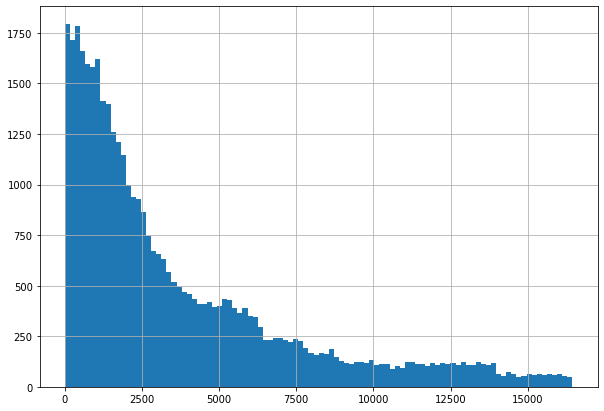

In [44]:
plt.rcParams['figure.figsize'] = (10, 7)
df_train['Ranking'].hist(bins=100)

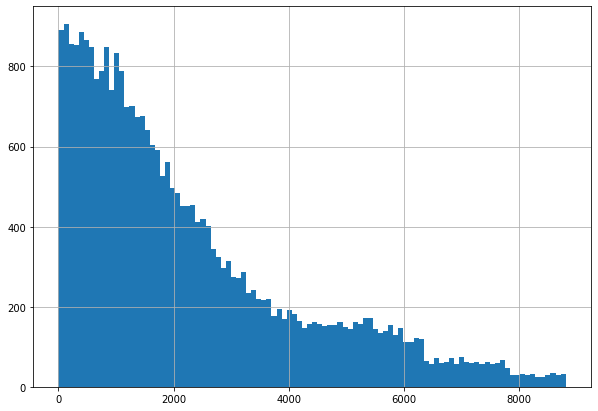

In [45]:
plt.rcParams['figure.figsize'] = (10, 7)
df_train[(df_train.City != 'London') & (
    df_train.City != 'Paris')]['Ranking'].hist(bins=100)

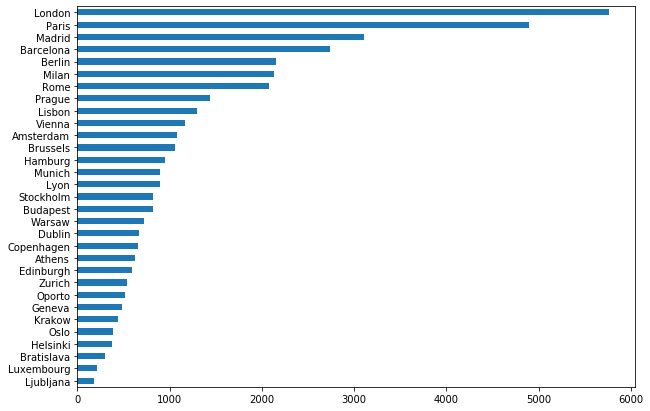

In [46]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

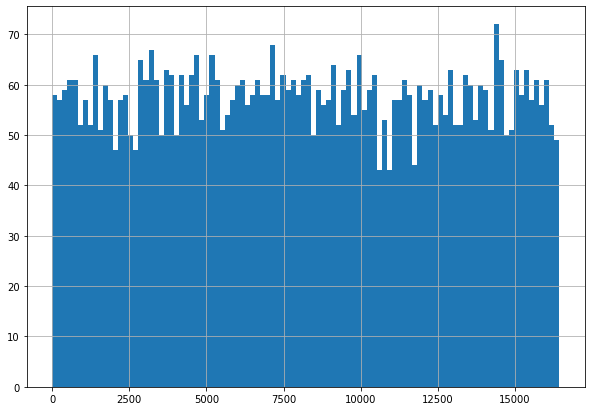

In [47]:
df_train['Ranking'][df_train['City'] == 'London'].hist(bins=100)

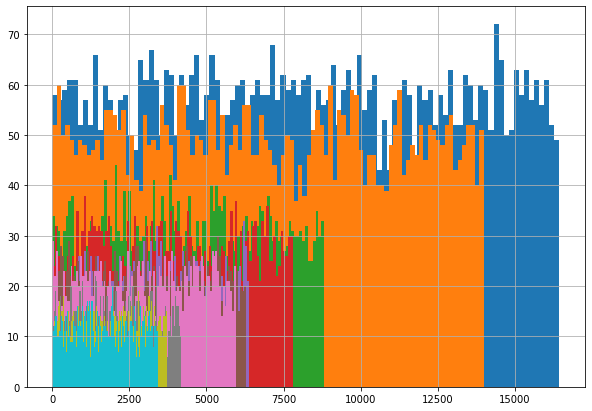

In [48]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Из этих графиков видно, что для конкретного города места распределены равномерно. Общая картина ranking.hist() выглядит так, потому что в больших городах в принципе больше возможных мест, чем в маленьких.

Вместо номера ресторана введем новый признак, показывающий, насколько близок ресторан к первому месту в своем городе. Это нужно т.к. города имеют разное количество ресторанов и к Ranking в разных городах нужно относиться по-разному. Например, 2000-е место в Лондоне - это неплохо, в Барселоне - нехорошо, а в Осло вообще нет столько ресторанов. 1 - лучший в своем городе 0 - худший x = 1- Ranking/Ranking.max() Ranking.max() имеется ввиду для данного города.

In [49]:
data1 = df_test.append(df_train, sort=False).reset_index(drop=True)

In [50]:
data['City'] = data1['City']

In [51]:
max_Ranking_on_City = data.groupby(['City'])['Ranking'].max()
#count_Restorant_in_City = df['City'].value_counts(ascending=False)
data['max_Ranking_on_City'] = data['City'].apply(
    lambda x: max_Ranking_on_City[x])
#df['count_Restorant_in_City'] = df['City'].apply(lambda x: count_Restorant_in_City[x])
data['norm_Ranking'] = (1 - data['Ranking'] / data['max_Ranking_on_City'])

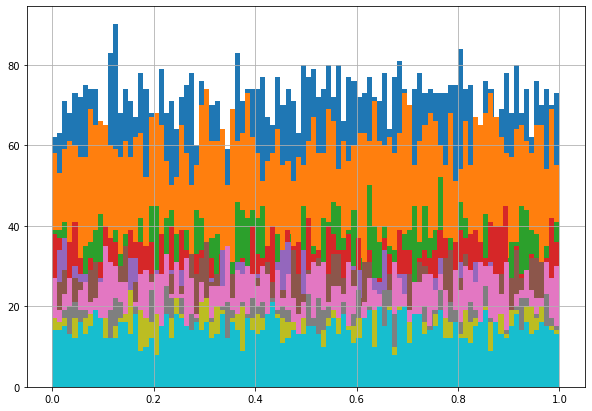

In [52]:
for x in (data['City'].value_counts())[0:10].index:
    data['norm_Ranking'][data['City'] == x].hist(bins=100)
plt.show()

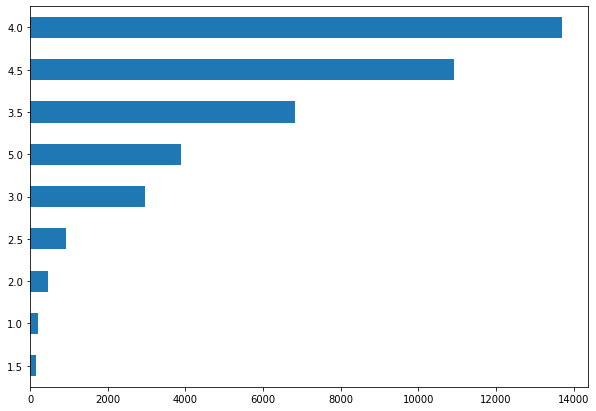

In [53]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

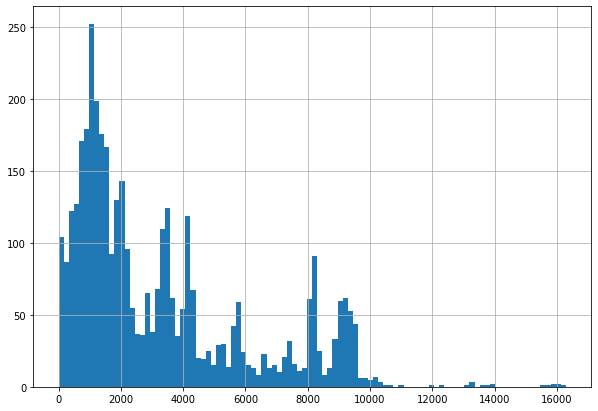

In [54]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

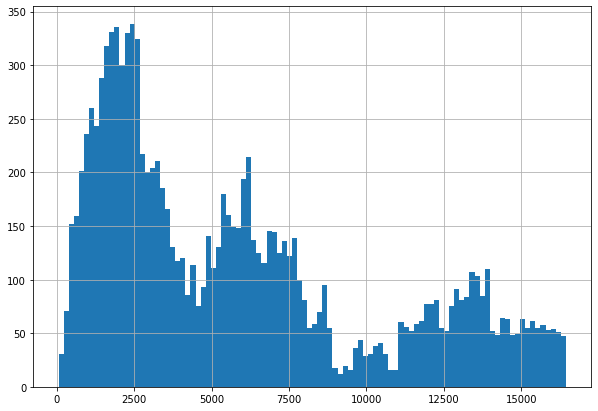

In [55]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

Рейтинг и место в городе сильно связаны. Добавим новый признак.
По МНК рассчитаем связь между рейтингом и ранкингом Raiting = m*Ranking_norm + c. По найденным коэффициентам построим новый признак pred_raiting. (Я не уверен, что это правильный ход. Возможно, randomForrest сам делает нечто подобное внутри себя? И еще, кажется, говорили, что скоррелированные признаки не стоит оставлять в dataframе. Теперь получится, что я подаю на вход модели линейно зависимые столбцы, нужно будет удалить norm_Ranking).

In [56]:
data1 = data[data['sample'] == 1]

In [57]:
A = np.vstack([data1['norm_Ranking'], np.ones(len(data1['norm_Ranking']))]).T

In [58]:
# Raiting = m*Ranking_norm + c
m, c = np.linalg.lstsq(A, data1['Rating'], rcond=None)[0]

In [59]:
data['pred_raiting'] = data['norm_Ranking'].apply(lambda x: m*x+c)

In [60]:
data.columns

Index(['Cuisine Style', 'Ranking', 'Price Range', 'Number of Reviews',
       'sample', 'Rating', 'City_Amsterdam', 'City_Athens', 'City_Barcelona',
       'City_Berlin', 'City_Bratislava', 'City_Brussels', 'City_Budapest',
       'City_Copenhagen', 'City_Dublin', 'City_Edinburgh', 'City_Geneva',
       'City_Hamburg', 'City_Helsinki', 'City_Krakow', 'City_Lisbon',
       'City_Ljubljana', 'City_London', 'City_Luxembourg', 'City_Lyon',
       'City_Madrid', 'City_Milan', 'City_Munich', 'City_Oporto', 'City_Oslo',
       'City_Paris', 'City_Prague', 'City_Rome', 'City_Stockholm',
       'City_Vienna', 'City_Warsaw', 'City_Zurich', 'alko', 'euro_rest',
       'fast_food', 'afric', 'sea_food', 'asia', 'americ', 's_americ',
       'special', 'other', 'No cuisine', 'Price_Range_isNAN',
       'Number_of_Reviews_isNAN', 'last_date', 'delta_now',
       'delta_between_two', 'City', 'max_Ranking_on_City', 'norm_Ranking',
       'pred_raiting'],
      dtype='object')

In [61]:
plt.rcParams['figure.figsize'] = (15, 10)
data[['Ranking', 'Price Range', 'Number of Reviews',
      'pred_raiting', 'norm_Ranking', 'max_Ranking_on_City']].corr()

,Ranking,Price Range,Number of Reviews,pred_raiting,norm_Ranking,max_Ranking_on_City
Ranking,1.000000,-0.244280,-0.223198,-0.570506,-0.570506,0.709068
Price Range,-0.244280,1.000000,0.312897,0.482829,0.482829,0.046516
Number of Reviews,-0.223198,0.312897,1.000000,0.407453,0.407453,0.025867
pred_raiting,-0.570506,0.482829,0.407453,1.000000,1.000000,0.003133
norm_Ranking,-0.570506,0.482829,0.407453,1.000000,1.000000,0.003133
max_Ranking_on_City,0.709068,0.046516,0.025867,0.003133,0.003133,1.000000


Проверим, что получилось.

In [62]:
data.columns

Index(['Cuisine Style', 'Ranking', 'Price Range', 'Number of Reviews',
       'sample', 'Rating', 'City_Amsterdam', 'City_Athens', 'City_Barcelona',
       'City_Berlin', 'City_Bratislava', 'City_Brussels', 'City_Budapest',
       'City_Copenhagen', 'City_Dublin', 'City_Edinburgh', 'City_Geneva',
       'City_Hamburg', 'City_Helsinki', 'City_Krakow', 'City_Lisbon',
       'City_Ljubljana', 'City_London', 'City_Luxembourg', 'City_Lyon',
       'City_Madrid', 'City_Milan', 'City_Munich', 'City_Oporto', 'City_Oslo',
       'City_Paris', 'City_Prague', 'City_Rome', 'City_Stockholm',
       'City_Vienna', 'City_Warsaw', 'City_Zurich', 'alko', 'euro_rest',
       'fast_food', 'afric', 'sea_food', 'asia', 'americ', 's_americ',
       'special', 'other', 'No cuisine', 'Price_Range_isNAN',
       'Number_of_Reviews_isNAN', 'last_date', 'delta_now',
       'delta_between_two', 'City', 'max_Ranking_on_City', 'norm_Ranking',
       'pred_raiting'],
      dtype='object')

In [63]:
data1 = data.drop(
    ['norm_Ranking', 'max_Ranking_on_City', 'Cuisine Style'], axis=1)

In [64]:
df_preproc = data1.drop(['City'], axis=1)

In [65]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Ranking                  50000 non-null  float64
 1   Price Range              50000 non-null  int64  
 2   Number of Reviews        50000 non-null  float64
 3   sample                   50000 non-null  int64  
 4   Rating                   50000 non-null  float64
 5   City_Amsterdam           50000 non-null  uint8  
 6   City_Athens              50000 non-null  uint8  
 7   City_Barcelona           50000 non-null  uint8  
 8   City_Berlin              50000 non-null  uint8  
 9   City_Bratislava          50000 non-null  uint8  
 10  City_Brussels            50000 non-null  uint8  
 11  City_Budapest            50000 non-null  uint8  
 12  City_Copenhagen          50000 non-null  uint8  
 13  City_Dublin              50000 non-null  uint8  
 14  City_Edinburgh        

In [66]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

In [67]:
y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.

In [68]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED)

**ML**

In [69]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

In [70]:
model = RandomForestRegressor(
    n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [71]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [72]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.200390625


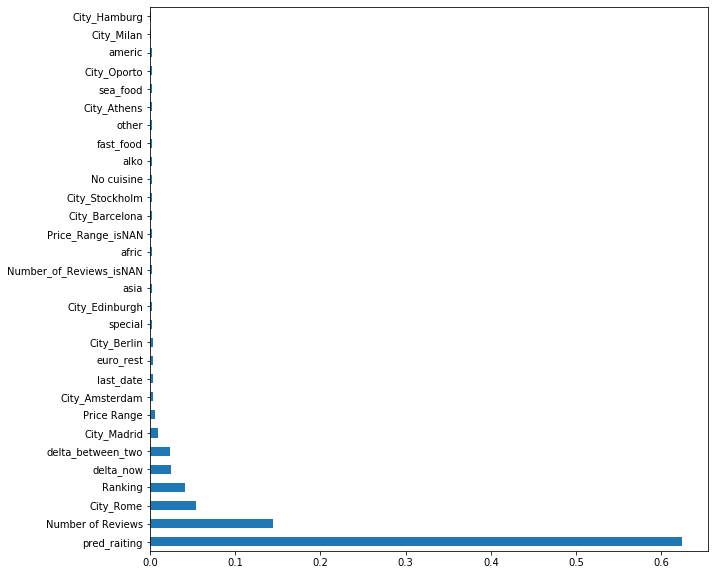

In [73]:
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

Решение на kaggle

In [74]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,...,s_americ,special,other,No cuisine,Price_Range_isNAN,Number_of_Reviews_isNAN,last_date,delta_now,delta_between_two,pred_raiting
248,9157.0,0,3.0,0.0,0,0,0,0,0,0,...,0,0,0,1,1,0,2016,1477,112.000000,3.919445
8721,2151.0,2,9.0,0.0,0,0,0,0,0,0,...,0,1,1,0,0,0,2017,1244,427.000000,3.508512
1075,6185.0,2,14.0,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,2017,1113,233.000000,3.395754
3369,6043.0,2,110.0,0.0,0,0,0,1,0,0,...,0,1,0,0,0,0,2017,1112,280.000000,3.423958
1131,16313.0,1,0.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,1,2017,1040,142.548832,3.368695
491,15496.0,0,21.0,0.0,0,0,0,0,0,0,...,0,0,0,1,1,0,2018,1009,15.000000,3.431574
1159,6321.0,2,38.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,2017,1143,11.000000,4.052214
5678,2532.0,2,8.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,2017,1296,198.000000,3.693750
5408,50.0,1,349.0,0.0,0,0,0,0,0,0,...,0,1,0,0,0,0,2018,1010,2.000000,4.598264
4191,4841.0,2,25.0,0.0,0,0,0,1,0,0,...,0,0,0,0,0,0,2015,1881,113.000000,3.662695


In [75]:
test_data = test_data.drop(['Rating'], axis=1)

In [76]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [77]:
sample_submission['Rating'] = predict_submission

In [78]:
answer = sample_submission  # это предсказания на тестовой части

In [79]:
answer.to_csv('submission.csv', index=False)